# Assignment 1

# 1. Regression

The goal of this part of assignment is to apply regression analysis using splines and advanced decision tree regression techniques on a real-world dataset. You will explore the dataset, preprocess it, apply different regression models, and compare their performance.

## Dataset
For this assignment, we will use the "California Housing Prices" dataset from the `sklearn.datasets` module for ease of access. 

### 1. Data Exploration and Preprocessing
- Load the California Housing Prices dataset.
- [Perform exploratory data analysis (EDA) to understand the dataset](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15).
- Visualize the distribution of the target variable and other features (plotting a histogram or a density plot of the target variable to see its distribution. This can reveal if the target is normally distributed, skewed, or has any unusual patterns.)
- Handle missing values if any (for now you can remove the observation).
- Normalize/standardize the features if required.

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Load the dataset
california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)
df = california_housing.frame
df.shape
df.head

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

<bound method NDFrame.head of        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Lo

# Initial thoughts

From the above we can see that the dataset has a sum of *20640* rows with 9 numerical predictors (one of these we are going to use for prediction -> house price). Using house prices as our dependent variable, and the other 8 variables: [Median Income, House Age, Average Rooms, Average Bedrooms, Population, Average Household Members, Latitude, Longitude] as predictors. Acording to the description of the data, there does not exist any missing values -> to be safe, we conduct missing values analysis to confirm this, together with visual inspections. Since we are working with with a numerical predictions, we work towards regression analysis. 

In [28]:
# Performing exploratory analysis.
# First we want to check if there are any missing values in the dataset.

df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

As we can see from the above output, there are no missing values in the dataset as the description stated. Now we want to perform visual inspections, to find potential patterns/hypotheses, spot anomalies and outliers. First I create simple plots to get a better understanding of the data.

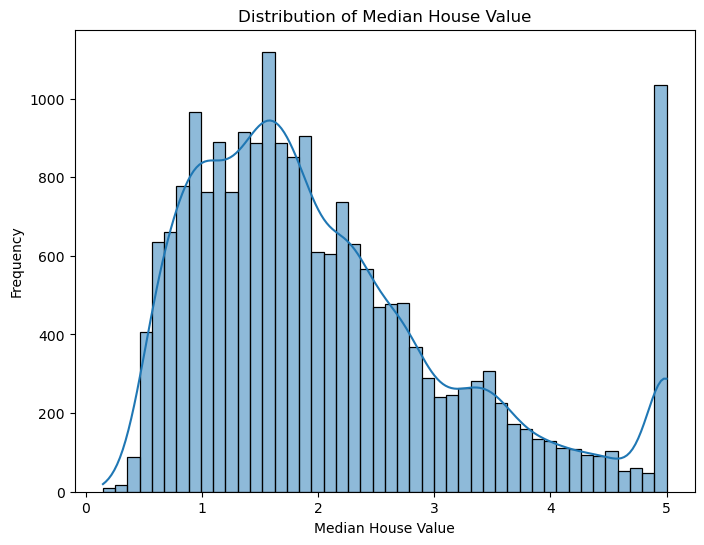

In [29]:
# Split the data into predictors and target

features = df.drop('MedHouseVal', axis=1)
target = df['MedHouseVal']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Exploring the data
# Plotting the distribution of the target variable

plt.figure(figsize=(8, 6))
sns.histplot(target, kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

If we look at the distribution of the target variable, we see that it tails of to the right, indicating that there is a longer tail on the right side of the distribution. At the far right, we see a spike in the frequency which could indicate that housing prices are capped at some specific level, in this case at 5. We need to be aware of this, because the model might not be able to pick this up under fitting and therefore reducing the accuracy of the model. 

Lets investigate if any of the variables have any outliers, or the distributions in the data has any significant pattern

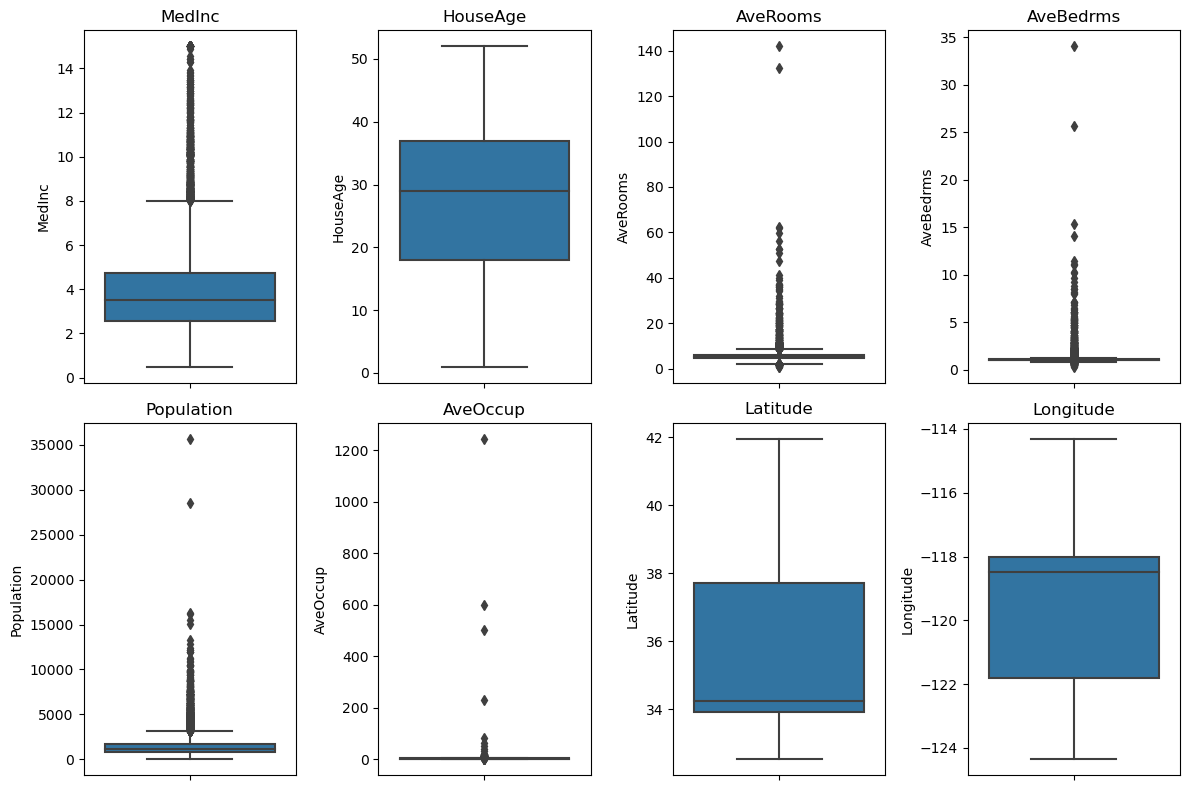

In [30]:
# Boxplot of variables
plt.figure(figsize=(12, 8))
for i, col in enumerate(features.columns):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=features[col])
    plt.title(col)
plt.tight_layout()
plt.show()

We see a significant portion of outliers for *Median Income*, this is expected after seeing the distribution for the housing prices as well, further indiciating that the housing prices have been capped. House age seems to fair uniformly distributed, a histogram will clear up whether this is the case or not. *Average rooms* seems to fairly centered around a specific value, but there are some significant outliers, the same goes for *average bedrooms*, which indicate a correlation. *Population* seems to be futher skewed with some outliers, indicating locations with many more habitants. *Average Occupancy* exhibits the same behavior. *Latitude* and *longitude* both seem to be uniformly distributed which would be expected. 

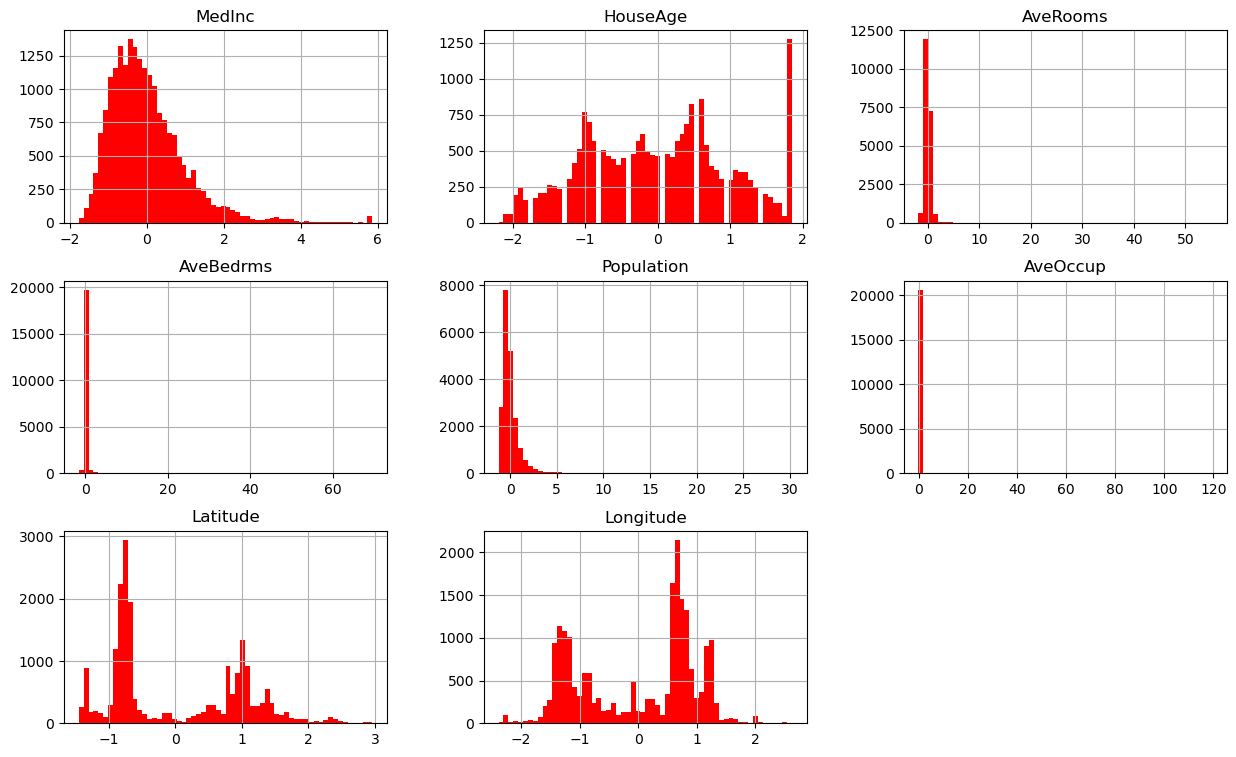

In [31]:
color1 = 'red'

scaled_features_df.hist(bins=60, figsize=(15,9), color=color1)
plt.show()

The histogram further confirm the initial inspection of the boxplots. 

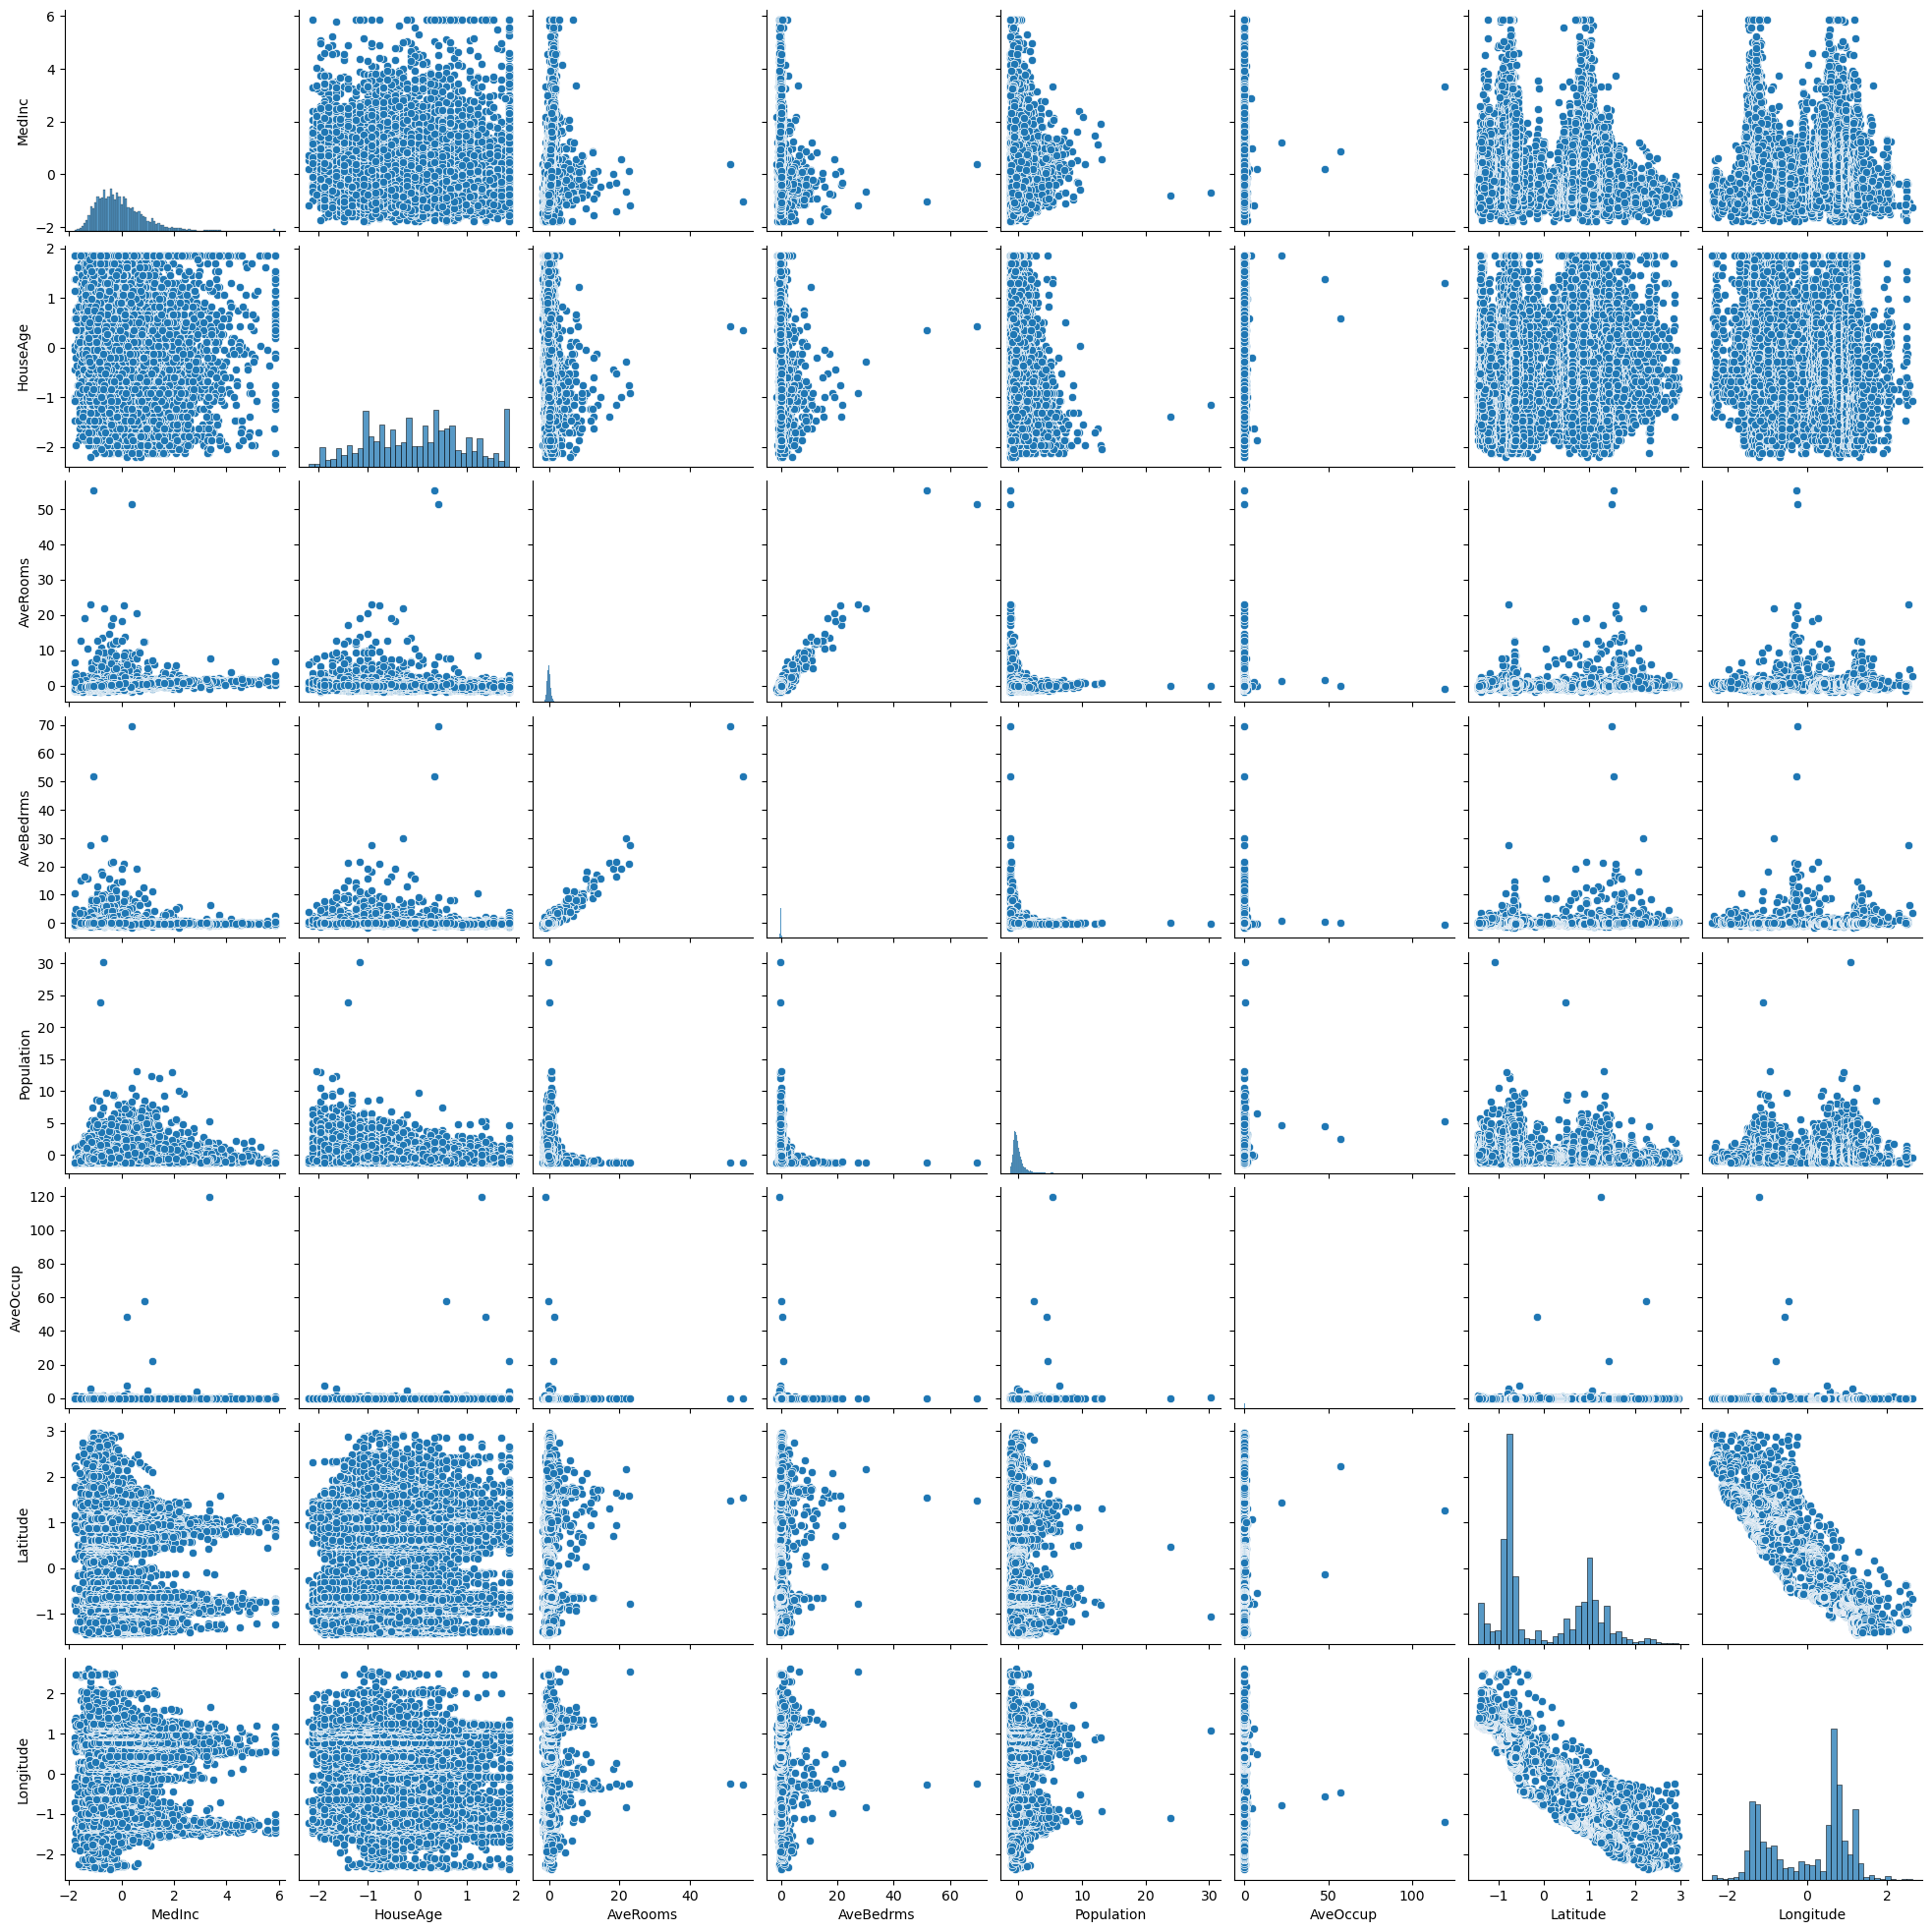

In [32]:
sns.pairplot(data = scaled_features_df, kind = 'scatter')

<Axes: >

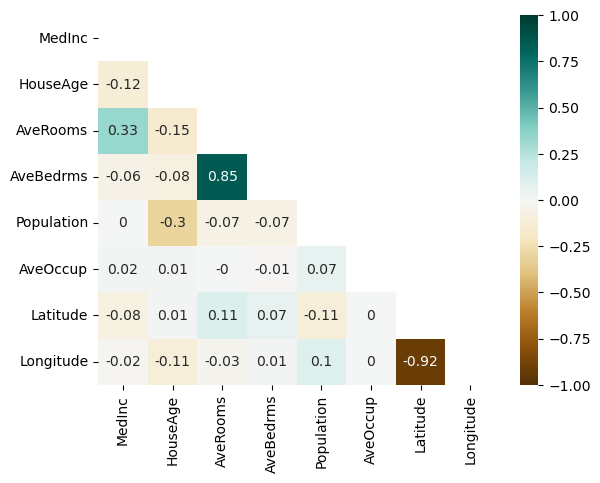

In [33]:
import numpy as np
import seaborn as sns
mask = np.triu(np.ones_like(scaled_features_df.corr(), dtype=np.bool_))

sns.heatmap(round(scaled_features_df.corr(),2), annot=True, cmap='BrBG', vmin=-1, vmax=1, mask=mask)

From the above correlation matrix displayed above, it is clear that some variables have high postive or negative correlation. The correlation between longitude and latitude is rather insignificant. We see high correlation between average bedrooms and average room, as well as a weak positive correlation for average rooms and median income. It can be good practice to remove some of the highly correlated variables during feature selection. 

### 2. Regression with Splines
- Fit a spline model to the data. You may use the `patsy` library in Python for creating spline features.
- Experiment with different degrees of freedom to see how the model complexity affects the performance.
- Evaluate the model using appropriate metrics (e.g., RMSE, R²).

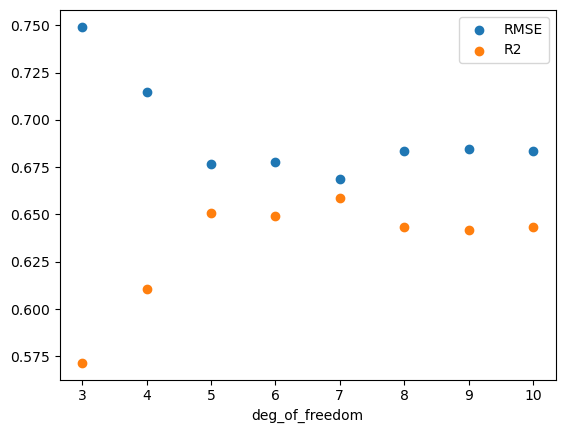

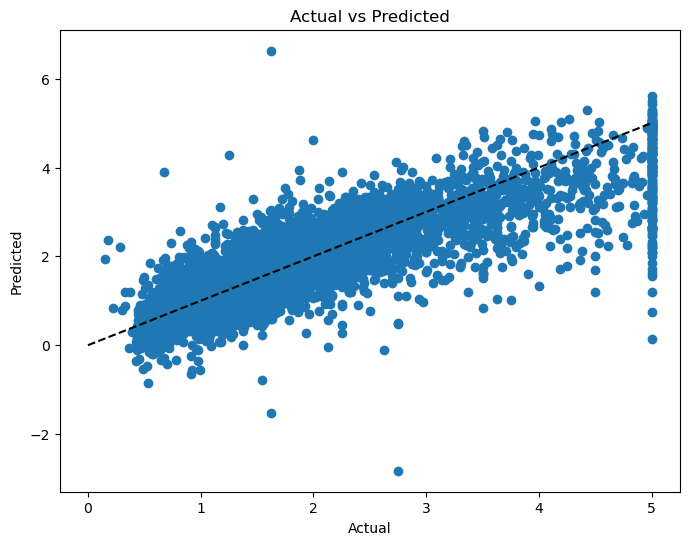

RMSE: 0.6837343092410755
R2: 0.6432467928745915


In [34]:
from patsy import dmatrix

X_train, X_test, y_train, y_test = train_test_split(scaled_features_df, target, test_size = 0.2, random_state = 42)

feature_names = scaled_features_df.columns

deg_of_freedom = np.arange(3,11)
rmse = []
r2 = []

for df in deg_of_freedom:
    
    
    formula = ' + '.join([f"cr({feature}, df="+str(df)+")" for feature in feature_names])
    
    transformed_X_train = dmatrix(formula, data=X_train, return_type='dataframe')
    transformed_X_test = dmatrix(formula, data=X_test, return_type='dataframe')

     # Fit the model
    model = LinearRegression()
    model.fit(transformed_X_train, y_train)

    # Predict on the test set
    spline_pred = model.predict(transformed_X_test)

    # Evaluate the model
    rmse.append(np.sqrt(mean_squared_error(y_test, spline_pred)))
    r2.append(r2_score(y_test, spline_pred))
    

plt.scatter(deg_of_freedom, rmse)
plt.scatter(deg_of_freedom, r2)
plt.xlabel('deg_of_freedom')
plt.legend(['RMSE' , 'R2'])
plt.show()

# Plot actual vs predictions for SPline

plt.figure(figsize=(8, 6))
plt.scatter(y_test, spline_pred)
plt.plot([0, 5], [0, 5], '--k')
plt.axis('tight')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Print relevant performance metrics

print('RMSE:', np.sqrt(mean_squared_error(y_test, spline_pred)))
print('R2:', r2_score(y_test, spline_pred))

Choosing the right amount of degrees of freedom is crucial in spline regression, as we are balancing the tradeoff between over- and underfitting the data. A higher degree, we allow for more complex patterns in the model, but at the risk of overfitting and getting a model that doesn't generalize well. Conversely, a too low amount can lead to underfitting.  

Having tried various amounts, I land on 11 degrees of freedom to achieve a model that neither over- or underfits the data. Raising the degrees of freedom any further will result in an overall lower $R^2$, but with a higher RMSE. Choosing for example 15 would result in a slight increase in $R^2$ and around the same RMSE, but choosing 4 more degrees of freedom and only achieving a marginal increase is not worthwhile compared to keeping a simpler model. 

### 3. Regression with ensemble Decision Trees
- Apply Random Forest, AdaBoost and GradientBoosting regression techniques (from `sklearn`)
- For each method, tune hyperparameters using cross-validation.
- Evaluate the models using appropriate metrics (e.g., RMSE, R²).

Model:   Random Forest
{'n_estimators': [100, 200], 'max_depth': [10, 20]}


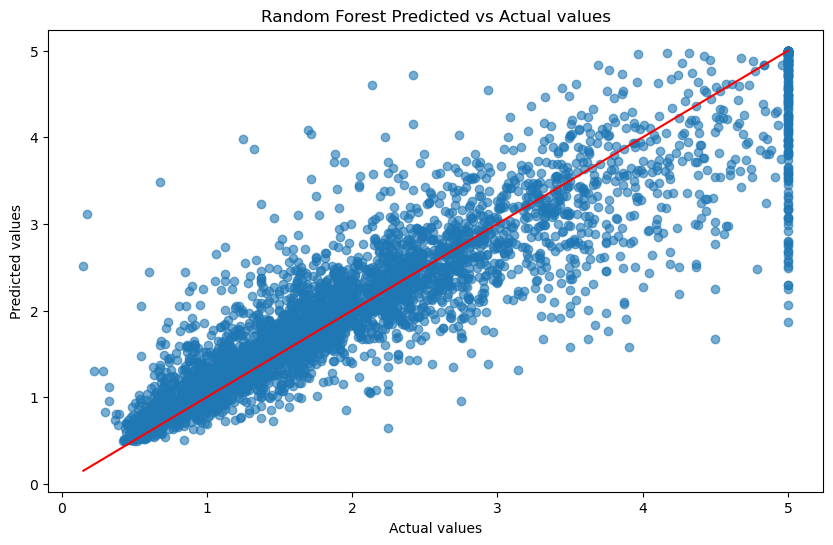

Model:   AdaBoost
{'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}


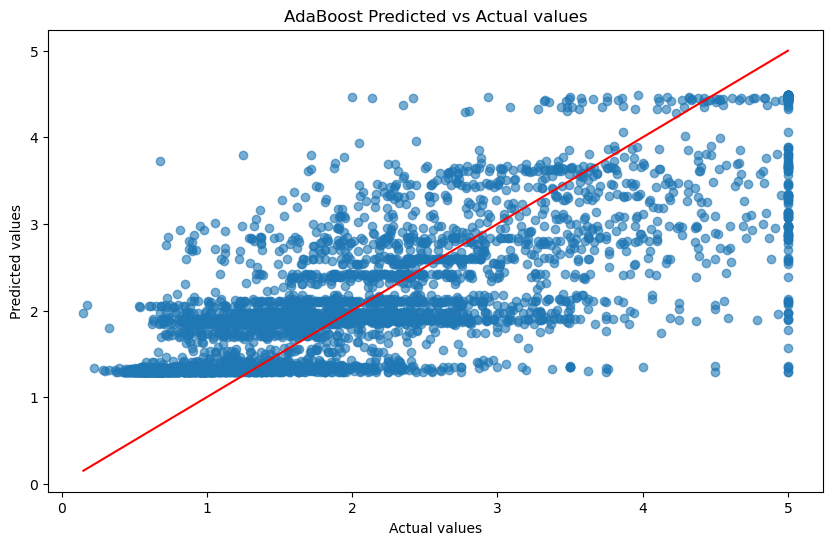

Model:   Gradient Boosting
{'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}


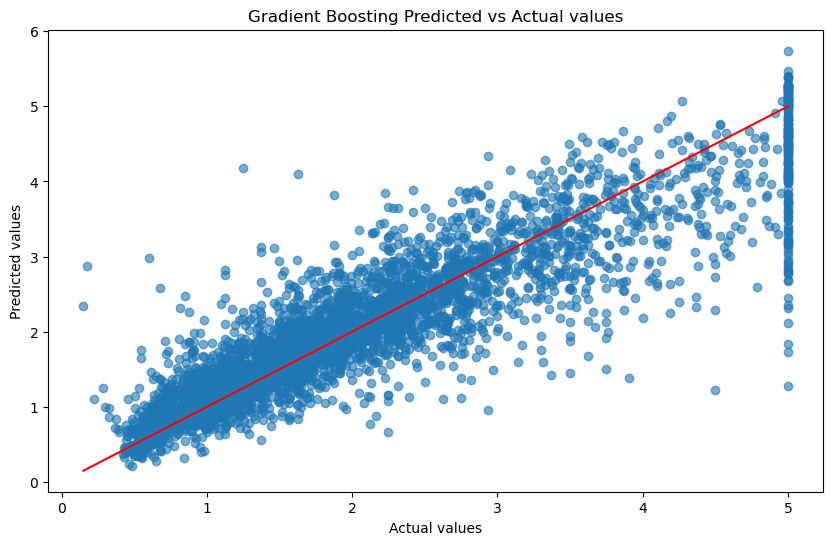

{'Random Forest': {'RMSE': 0.5048160712235051, 'R2': 0.8055269232757909, 'Best Params': {'n_estimators': 200, 'max_depth': 20}}, 'AdaBoost': {'RMSE': 0.7615830967444517, 'R2': 0.5573833643711172, 'Best Params': {'n_estimators': 200, 'learning_rate': 0.01}}, 'Gradient Boosting': {'RMSE': 0.5113702537480528, 'R2': 0.8004443339747364, 'Best Params': {'n_estimators': 200, 'learning_rate': 0.1}}}
CPU times: user 4min 5s, sys: 1.51 s, total: 4min 6s
Wall time: 4min 6s


In [35]:
%%time
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

# Storing model performance
model_performance = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=4, scoring='neg_mean_squared_error', njobs=-1)
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    # Predict on test set
    tree_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, tree_pred))
    r2 = r2_score(y_test, tree_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Visualization: Predicted vs Actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, tree_pred, alpha=0.6)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'{model_name} Predicted vs Actual values')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
    plt.show()

# Output model performance
print(model_performance)

### 4. Model Comparison
- Compare the performance of the spline models with the advanced decision tree regression models.
- Use visualizations to compare the predicted vs actual values for each model.
- Discuss the bias-variance tradeoff for each model based on your results.

### Bias-Variance Tradeoff in Different Regression Models

- **Bias**: Error due to overly simplistic assumptions, leading to underfitting.
- **Variance**: Error due to excessive complexity, leading to overfitting.

An ideal model minimizes both bias and variance. 

#### 1. Spline Regression
- **Bias**: Moderate. Assumes relationships can be modeled as piecewise polynomial functions, which can be restrictive but works well for smooth data.
- **Variance**: Controlled by the number and placement of knots. More knots increase variance, leading to potential overfitting, while fewer knots may lead to underfitting.

#### 2. Random Forest
- **Bias**: Generally low. Models complex relationships without strong assumptions on data distribution.
- **Variance**: Reduced by averaging multiple trees. However, too many trees or overly deep trees can lead to overfitting.

#### 3. AdaBoost (Adaptive Boosting)
- **Bias**: Initially high but reduced iteratively. Focuses on misclassified instances, thereby improving model accuracy over iterations.
- **Variance**: Can increase with the number of boosting rounds, leading to overfitting if not properly managed.

#### 4. Gradient Boosting
- **Bias**: Similar to AdaBoost, it sequentially adds models to correct previous errors, effectively reducing bias.
- **Variance**: Higher than random forests. Sensitive to overfitting with many boosting rounds or complex base learners. Regularization techniques can help manage this.


### 5. Analysis and Discussion
- Discuss the performance of each model and the impact of hyperparameters on the outcome.

- Provide insights on which features are most important for predicting housing prices.

In the code below I have printed the models out as a pandas dataframe to display the evaluation metrics and hypterparameters. 

**Random Forest** -> The amount of trees, more trees can overall improve the models stability and also accuracy, but will increase computational cost. So a specific treshold, adding additional trees will exhibit diminishing returns. It is important we do not train the model without having to use too many trees, since at a specific point, the error will not reduce further by adding more trees. Choosing the *maximum depth* is also crucial for this model, creating deep rooted trees can result in overfitting and poor generalization, but they will be able to capture much more complex patterns in the data, also at a higher computational cost. Using cross-validation to tune this parameter ends at a depth of 20, which seems very reasonable. Through the RandomizedSearchCV() function, the random forest has 200 trees with a maximum depth of 20 through hyperparameter tuning. 

**AdaBoost** -> We use between 100 and 200 weak learners for the Adaboost case. Using more weak learners can improve the model's accuracy, but just like Random Forest, the performance gain may not be favorable. Increasing this can result in overfitting. Using a low learning rate here means that the weak learners have a smaller impact on the model, possibly requiring more weak learners in order to converge. Choosing too high a learning rate will speed up the training, but the model can potentially overshoot and thereby not decrease the loss of the model. From the table below, the hypertuning amounted to 200 weak learners with 0.01 learning rate, which also showcases the tradeoff between more weak learners and lower learning rate. 

**Gradient Boosting** -> The n_estimators sets the amount of boosting stages to run. As with Adaboost and Random Forest, using more stages can result in a model that performs better on the training data, but at the risk of overfitting and increased computational cost. As with Adaboost, using a low learning rate might require more stages to be run in order to speed up the training process. A higher learning rate can speed up convergence, but the model might miss it's disered optimization point. Below we see that hypertuning amounted to 200 stages and a learning rate of 0.1. 

In [36]:
model_performance = pd.DataFrame(model_performance)
print(model_performance)

                                      Random Forest  \
RMSE                                       0.504816   
R2                                         0.805527   
Best Params  {'n_estimators': 200, 'max_depth': 20}   

                                                 AdaBoost  \
RMSE                                             0.761583   
R2                                               0.557383   
Best Params  {'n_estimators': 200, 'learning_rate': 0.01}   

                                       Gradient Boosting  
RMSE                                             0.51137  
R2                                              0.800444  
Best Params  {'n_estimators': 200, 'learning_rate': 0.1}  


Random Forest Feature Importance
            Importance
MedInc        0.525037
AveOccup      0.138564
Latitude      0.088855
Longitude     0.088669
HouseAge      0.054558
AveRooms      0.044195
Population    0.030503
AveBedrms     0.029620

AdaBoost Feature Importance
            Importance
MedInc        0.420941
Longitude     0.159352
Latitude      0.146282
AveOccup      0.125988
AveRooms      0.060222
HouseAge      0.040109
Population    0.029541
AveBedrms     0.017566

Gradient Boosting Feature Importance
            Importance
MedInc        0.604259
AveOccup      0.122835
Longitude     0.109853
Latitude      0.098533
HouseAge      0.034113
AveRooms      0.023948
AveBedrms     0.005106
Population    0.001354



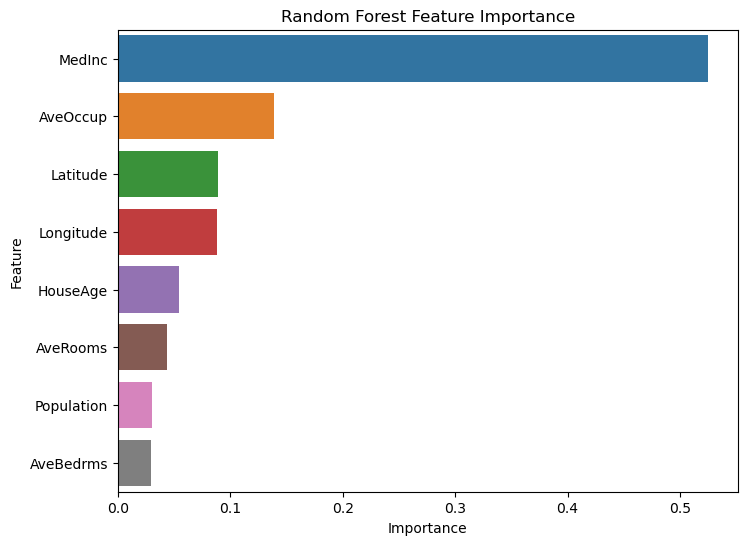

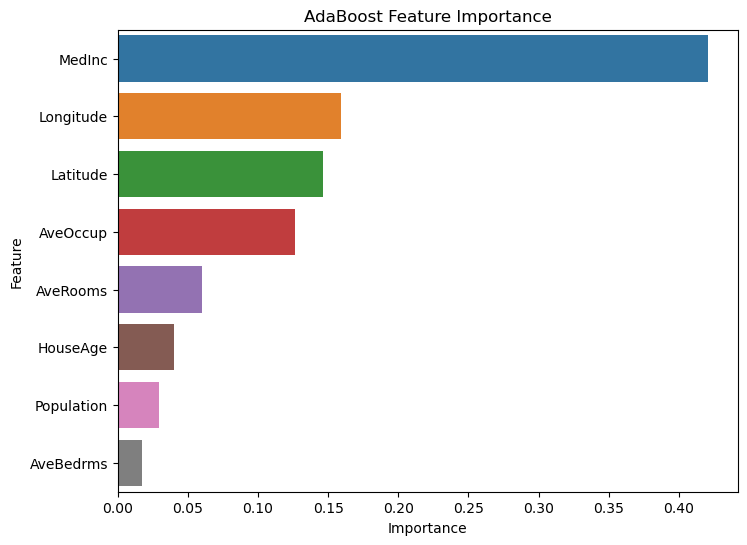

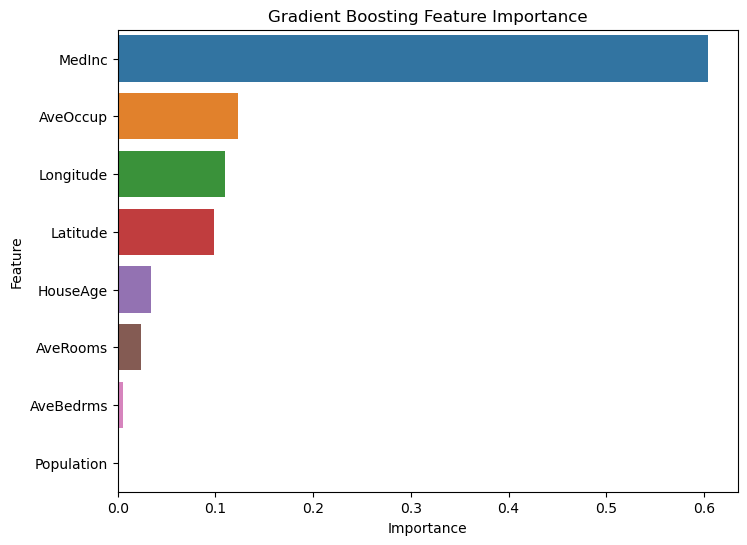

In [39]:
def get_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    feature_importance = pd.DataFrame(feature_importance, index=feature_names, columns=['Importance'])
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
    return feature_importance

# Get feature importance for each model
for model_name in models:
    model = models[model_name]
    model.fit(X_train, y_train)
    feature_importance = get_feature_importance(model, feature_names)
    print(f'{model_name} Feature Importance')
    print(feature_importance)
    print()

# Plot feature importance for each model

for model_name in models:
    model = models[model_name]
    model.fit(X_train, y_train)
    feature_importance = get_feature_importance(model, feature_names)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance.index)
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# 2. Classification
In this assignment, you will apply various classification techniques on a dataset to predict categorical outcomes. You will use Support Vector Machines (SVM), advanced decision tree classifiers, and Generalized Additive Models (GAMs) to build predictive models and compare their performance.

## Dataset
We will use the "Breast Cancer Wisconsin (Diagnostic)" dataset for this assignment. This dataset is included in the `sklearn.datasets` module.

## Tasks

### 1. Data Exploration and Preprocessing
* Begin by loading the dataset and conducting exploratory data analysis (EDA).
* Visualize the distribution of the classes (malignant and benign) and the features.
* Preprocess the data by handling missing values, encoding categorical variables if necessary, and scaling the features.

In [9]:
# Load breast cancer wisconsin (diagnostic) dataset from sklearn.datasets
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

As we can see above, we have 30 numeric variables, therefore there is no need for encoding categorical variables. 

In [10]:
# Exploratory data analysis

# split the data into predictors and target

features = data.data
target = data.target

# Check the shape of the data
print(data.data.shape)

# Check the target names
print(data.target_names)

# Check the feature names
print(data.feature_names)

# Convert the data into a pandas dataframe
import pandas as pd

df_pd = pd.DataFrame(data.data, columns=data.feature_names)

(569, 30)
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [11]:
# Check for missing values
print(df_pd.isnull().sum())

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


In [12]:
# Summary statistics
summary_stats = df_pd.describe().to_string(float_format="{:.2f}".format)
print(summary_stats)

       mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension
count       569.00        569.00          569.00     569.00           569.00            569.00          569.00               569.00         569.00                  569.00        569.00         569.00           569.00      569.00            569.00             569.00           569.00                569.00          569.00                   569.00        569.00         569.00           569.00      569.00            569.00             569.00           569.00                569.00

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

x_df = pd.DataFrame(scaled_features, columns=data.feature_names)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3, random_state=42)

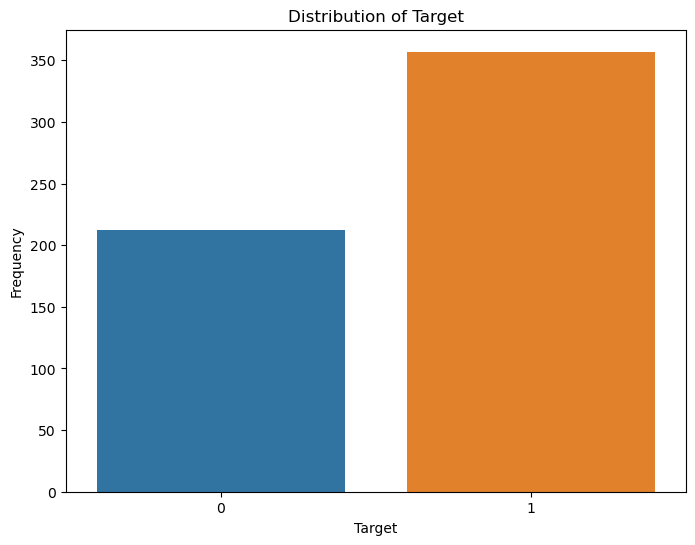

In [14]:
# Visualizing the two target classes
plt.figure(figsize=(8, 6))
sns.countplot(x=target)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

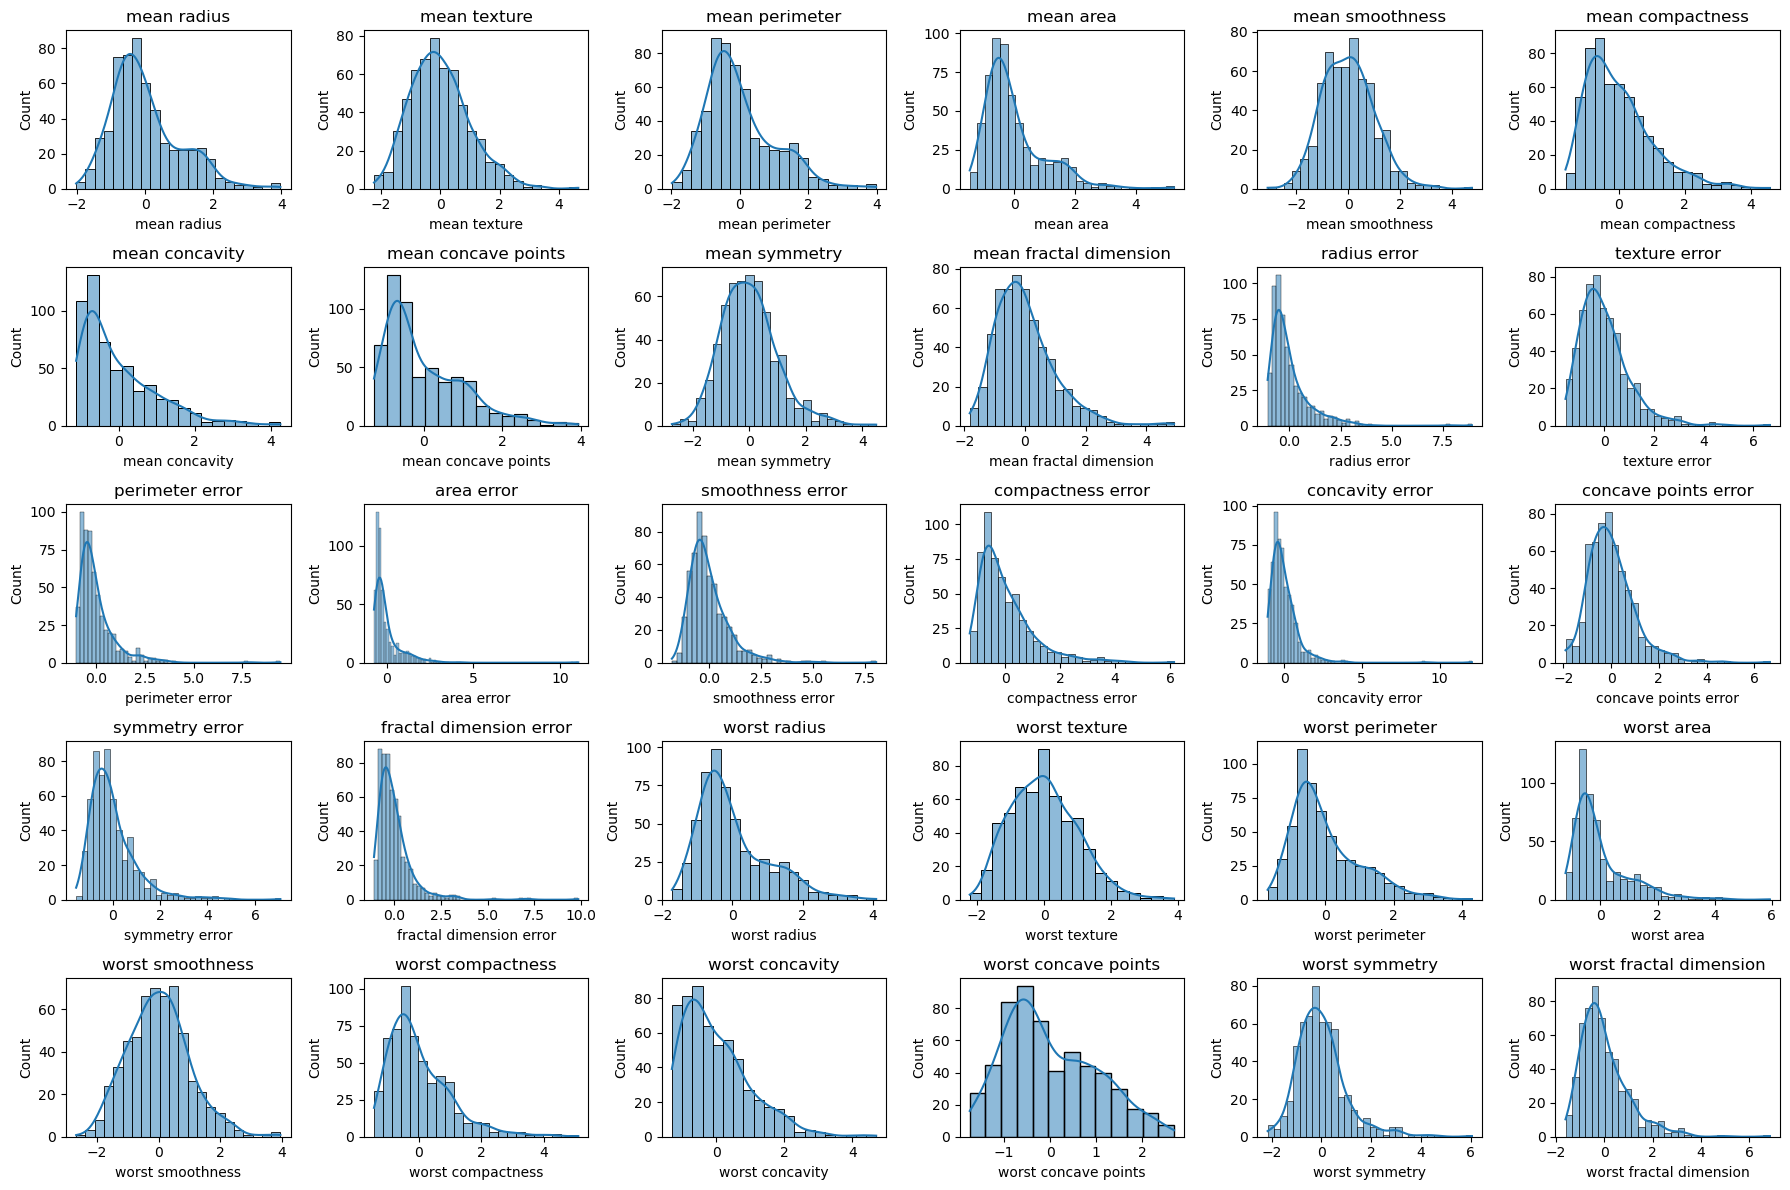

In [15]:
# Visualize the distribution of target and features
plt.figure(figsize=(18, 12))  # Adjust the figure size as per your preference
for i, col in enumerate(x_df.columns):
    plt.subplot(5, 6, i+1)
    sns.histplot(x_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

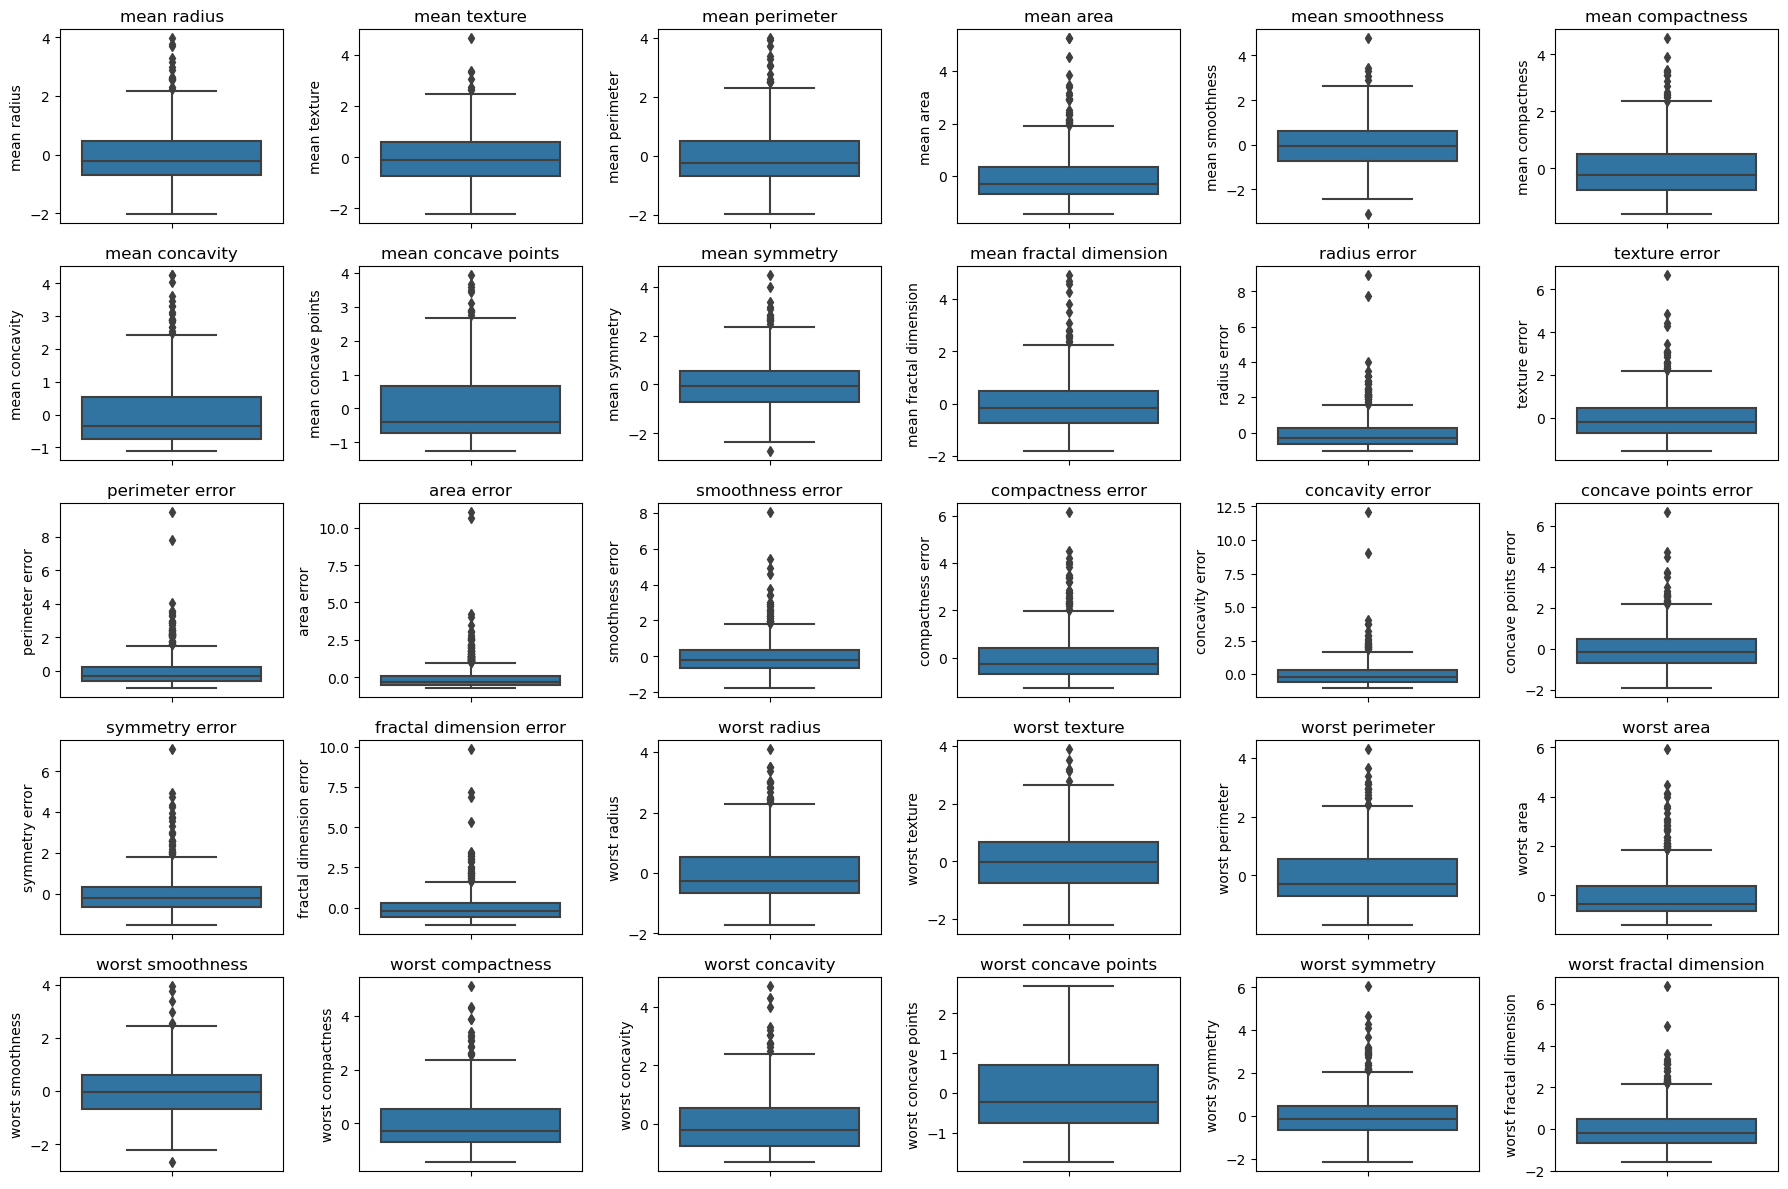

In [16]:
# Boxplots of the features
plt.figure(figsize=(18, 12))  # Adjust the figure size as per your preference
for i, col in enumerate(x_df.columns):
    plt.subplot(5, 6, i+1)
    sns.boxplot(y=x_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

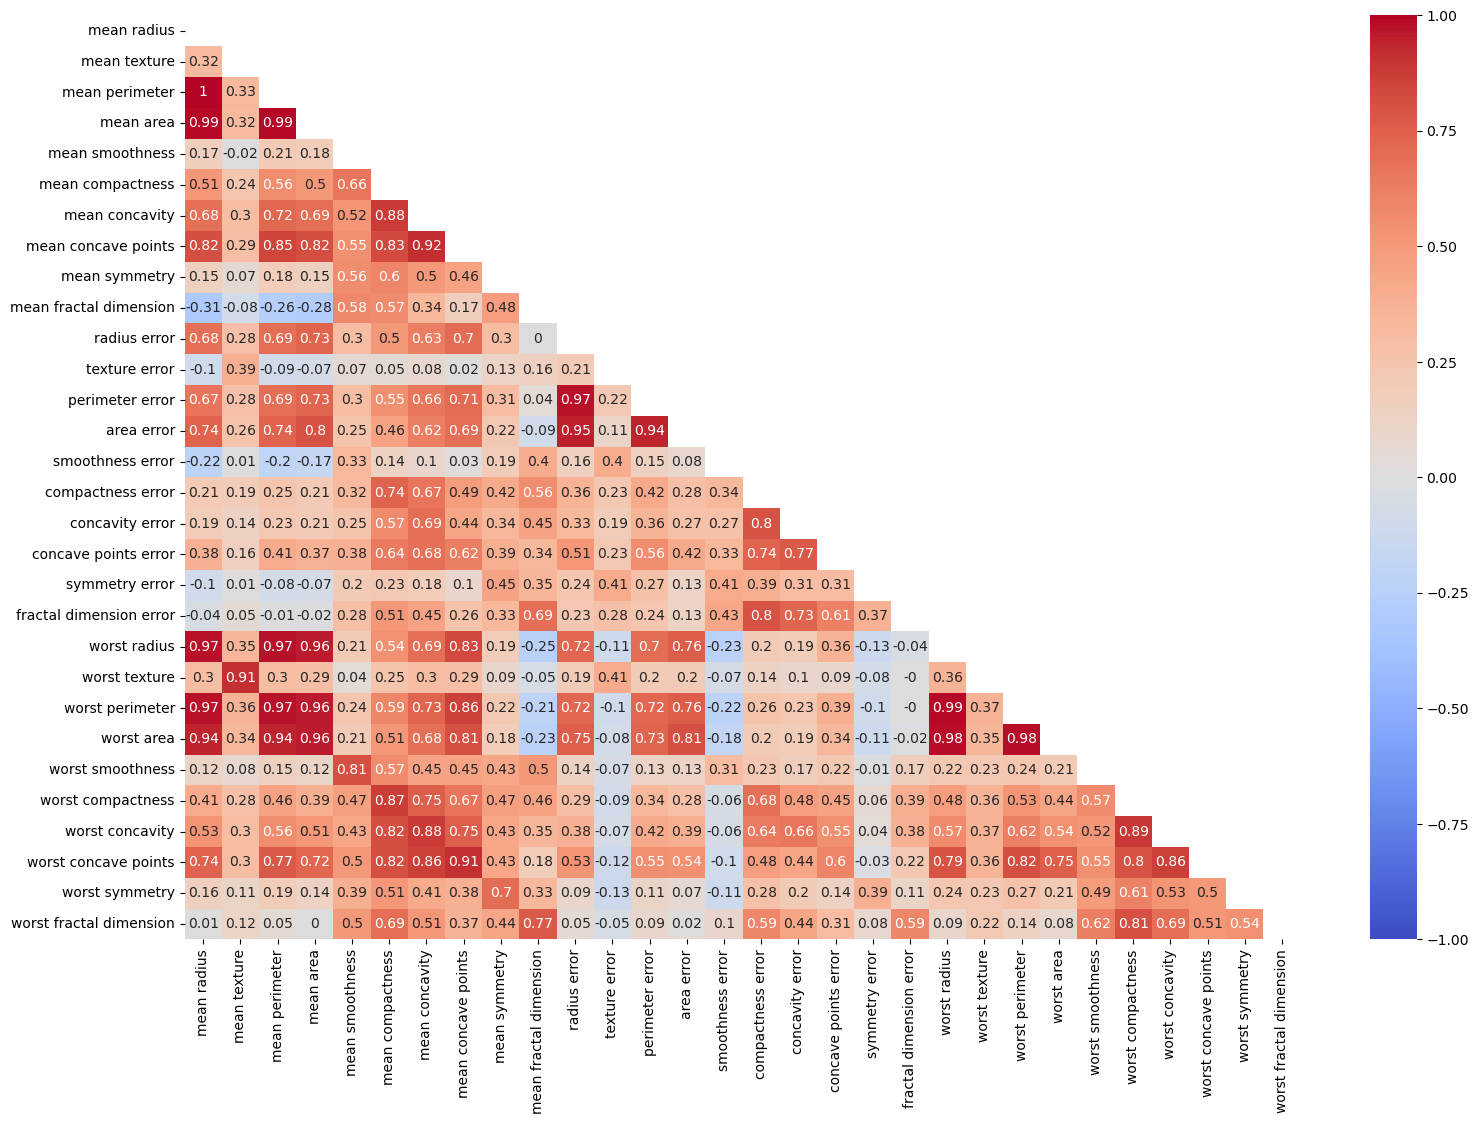

In [17]:
# Bivariate correlation plot
mask = np.triu(np.ones_like(x_df.corr(), dtype=bool))

# Bivariate correlation plot using seaborn
plt.figure(figsize=(18, 12))  # Adjust the figure size as per your preference
sns.heatmap(round(x_df.corr(),2), annot=True,  cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.show()

### 2. Classification with Support Vector Machines (SVM)
* Train an SVM classifier using the preprocessed data.
* Experiment with different kernels (linear, polynomial, and radial basis function) and regularization parameters.
* Evaluate the model using appropriate metrics (accuracy, precision, recall, F1-score, and ROC-AUC).

The first metric, **Accuracy**, measures the number of correct predictions over all predictions:  

$\frac{True Positives + True Negatives}{True Positives + True Negatives + False Negatives + False Positives} = $  

$\frac{N. of Correct Predictions}{N. of all Predictions} = $  

$\frac{N. of Correct Predictions}{Size of Dataset}$  

Second is **Precision**, measuring how many of the positive predictions made are correct -> True Positives.  

$\frac{True Positives}{True Positives + False Positives} = $  

$\frac{N. of Correctly Predicted Positives Instances}{N. of Total Positive Predictions you Made} = $  

$\frac{N. of Correctly Predicted People with Cancer}{N. of people you Predicted to have Cancer}$  

Third is **Recall**, measuring how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.  

$\frac{True Positives}{True Positives + False Negatives} = $  

$\frac{N. of Correctly Predicted Positives Instances}{N. of Total Positive Instances in the Dataset} = $  

$\frac{N. of Correctly Predicted People with Cancer}{N. of People with cancer in the Dataset}$  

Fourth is **F1-Score** which measures a combination of precision and recall.  

$2 * \frac{Precision * Recall}{Precision + Recall}$


In [134]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Classification with SVM
param_grid = {
    'linear': {'C': [0.1, 1, 10, 100]},
    'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0, 1]},
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
}

svm_results = {}
svm_results_pd = {}

for kernel in ['linear', 'poly', 'rbf']:
    svm = SVC(kernel=kernel)
    grid_search = GridSearchCV(svm, param_grid[kernel], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_svm = grid_search.best_estimator_

    # Predictions and Evaluation
    y_pred = best_svm.predict(X_test)
    accuracy = best_svm.score(X_test, y_test)
    precision, recall, f1, _ = classification_report(y_test, y_pred, output_dict=True)['weighted avg'].values()
    roc_auc = roc_auc_score(y_test, y_pred)

    svm_results[kernel] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    svm_results_pd[kernel] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

# Display results
pd.DataFrame(svm_results)

linear                               poly  \
Best Parameters  {'C': 1}  {'C': 1, 'coef0': 1, 'degree': 4}   
Accuracy         0.976608                           0.976608   
Precision        0.976608                           0.976608   
Recall           0.976608                           0.976608   
F1 Score         0.976608                           0.976608   
ROC-AUC          0.974868                           0.974868   

                                          rbf  
Best Parameters  {'C': 100, 'gamma': 'scale'}  
Accuracy                             0.953216  
Precision                            0.954861  
Recall                               0.953216  
F1 Score                             0.953495  
ROC-AUC                              0.956349

The *Linear Model* performs very well across all metrics - thereby indicating a strong linear separability of the data, so this model should generalize well.  

The *Polynomial Model* also performs very well across all metrics. This is a bit surprising since the hypertuning selected a degree of 4 for the polynomials, which is rather high and can introduce significant non-linearity to the model.  

The *Radial Basis Function* also performed very well, but a bit worse than the linear and polynomial.  

Even though these models performed very well for this dataset, they might be overfitting the data, especially considering a degree of 4 for polynomial model. We do not want the models to be too simple or rigid -> causing overfitting or too flexible and complex which might lead to underfitting. One might in the future consider regularization in order to avoid overfitting the data.

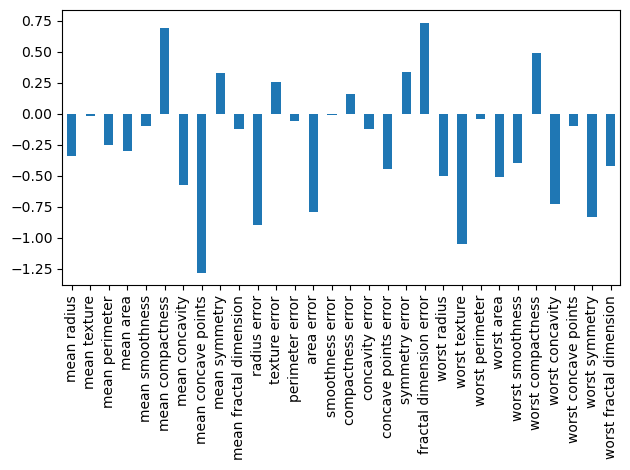

In [122]:
# Only for linear kernel because for others
# data is transformed by kernel method to another space.

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

svm_importance = pd.Series(svm.coef_[0], index=data.feature_names)

fig, ax = plt.subplots()
svm_importance.plot.bar( ax=ax)
fig.tight_layout()

### 3. Classification with Advanced Decision Trees

* Apply advanced decision tree classification techniques such as Random Forest and Gradient Boosting.
* Tune hyperparameters with cross-validation.

* Evaluate the models using the same metrics as for SVM.

In [138]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classification with Advanced Decision Trees
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(gb, gb_params, cv=5, n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)

# Metrics for Random Forest and Gradient Boosting
rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_rf)
}

gb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb),
    'Recall': recall_score(y_test, y_pred_gb),
    'F1 Score': f1_score(y_test, y_pred_gb),
    'ROC-AUC': roc_auc_score(y_test, y_pred_gb)
}

results = {'Random Forest': rf_metrics, 'Gradient Boosting': gb_metrics}
pd.DataFrame(results)

Random Forest  Gradient Boosting
Accuracy        0.970760           0.959064
Precision       0.963964           0.963303
Recall          0.990741           0.972222
F1 Score        0.977169           0.967742
ROC-AUC         0.963624           0.954365

Again we see that the models perform very well, here with *Random Forest* and *Gradient Boosting*. As before, regularization might be the way forward for these models. 

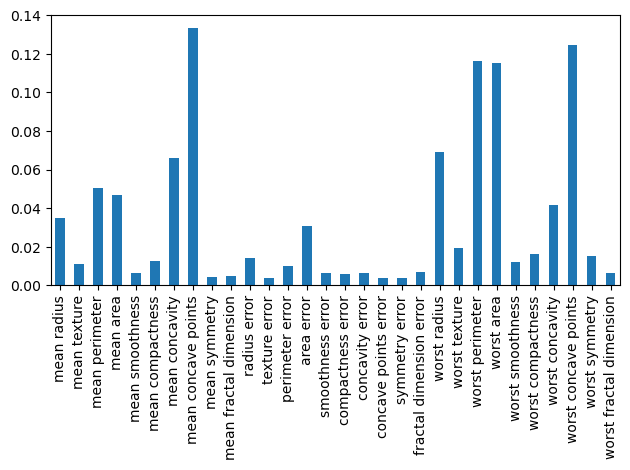

In [124]:
# Random forest feature importance
rf_importance = pd.Series(rf_best.feature_importances_, index=data.feature_names)

fig, ax = plt.subplots()
rf_importance.plot.bar(ax=ax)
fig.tight_layout()

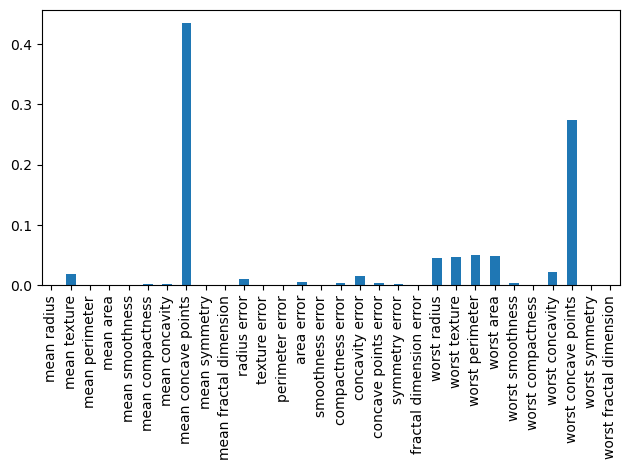

In [125]:
# Gradient boosting feature importance
gb_importance = pd.Series(gb_best.feature_importances_, index=data.feature_names)

fig, ax = plt.subplots()
gb_importance.plot.bar(ax=ax)
fig.tight_layout()


### 4. Classification with Generalized Additive Models (GAMs)

* Fit a GAM for classification using the `pyGAM` library.

* Select appropriate link functions and distribution families for the binary classification task.
* Visualize the contribution of each feature to the model using partial dependency plots.
* Evaluate the model using the same metrics as for SVM and decision trees.

In [126]:
from pygam import LogisticGAM, s, te

# Classification with Generalized Additive Models (GAMs)
gam_full = LogisticGAM().fit(X_train, y_train)

y_pred_gam_full = gam_full.predict(X_test)

# Metrics for GAM
gam_full_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gam_full),
    'Precision': precision_score(y_test, y_pred_gam_full),
    'Recall': recall_score(y_test, y_pred_gam_full),
    'F1 Score': f1_score(y_test, y_pred_gam_full),
    'ROC-AUC': roc_auc_score(y_test, y_pred_gam_full)
}
pd.DataFrame({'GAM':gam_full_metrics})

did not converge


GAM
Accuracy   0.976608
F1 Score   0.981651
Precision  0.972727
ROC-AUC    0.971561
Recall     0.990741

In [127]:
gam = LogisticGAM(s(0, n_splines=10) + s(1) + s(2) + s(6)+ s(8)+ te(5,8, n_splines =[13,13])  ).fit(X_train, y_train)

y_pred_gam = gam.predict(X_test)

# Metrics for GAM
gam_new_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gam),
    'Precision': precision_score(y_test, y_pred_gam),
    'Recall': recall_score(y_test, y_pred_gam),
    'F1 Score': f1_score(y_test, y_pred_gam),
    'ROC-AUC': roc_auc_score(y_test, y_pred_gam)
}
pd.DataFrame({'GAM':gam_new_metrics})

GAM
Accuracy   0.970760
F1 Score   0.977169
Precision  0.963964
ROC-AUC    0.963624
Recall     0.990741

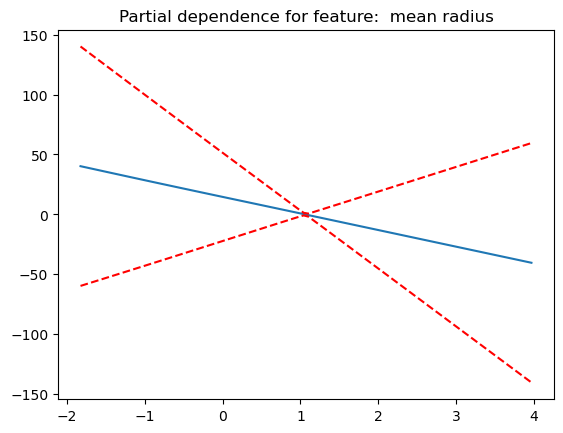

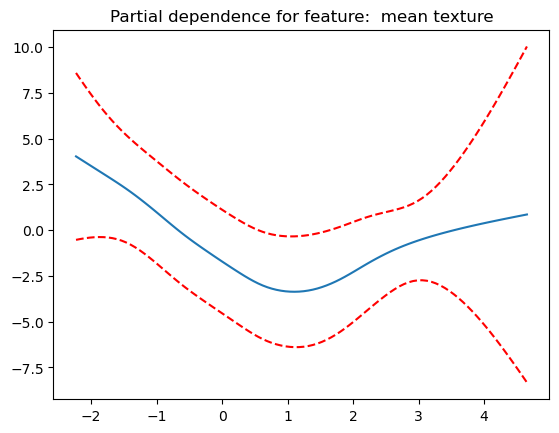

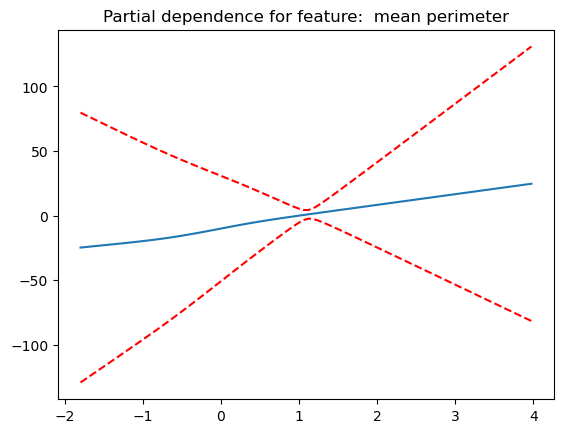

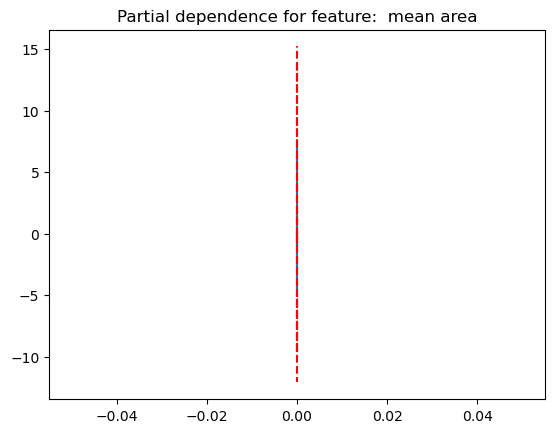

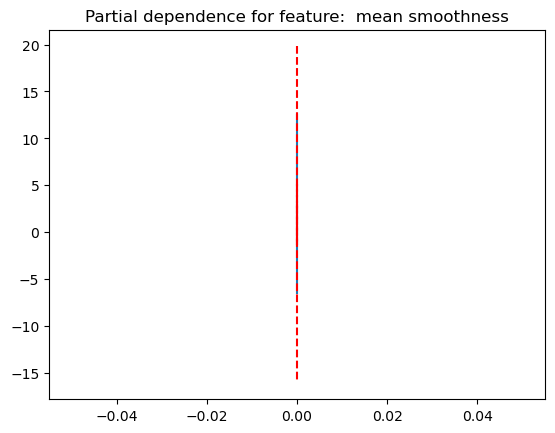

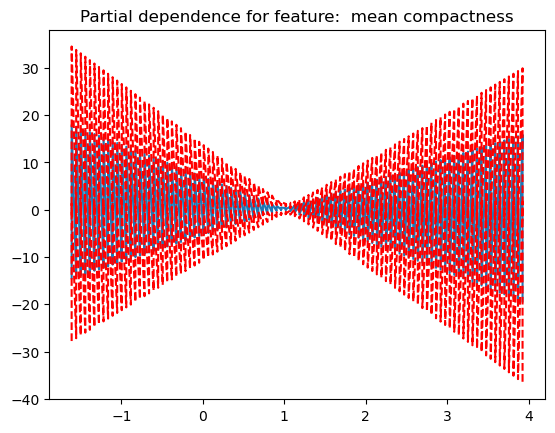

In [128]:
f = data.feature_names

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(f'Partial dependence for feature:  {f[i]}')
    plt.show()


### 5. Model Comparison and Analysis
* Compare the performance of SVM, advanced decision trees, and GAMs.
* Use confusion matrices and ROC curves to visualize the performance differences.
* Discuss the strengths and weaknesses of each model in the context of the dataset.

In [139]:
# Combine results
results = {'Random Forest': rf_metrics, 
           'Gradient Boosting': gb_metrics,
           'SVM_linear':svm_results_pd['linear'],
           'SVM_poly':svm_results_pd['poly'],
           'SVM_RBF':svm_results_pd['rbf'],
           'GAM': gam_new_metrics,
           'GAM_full': gam_full_metrics
          }
pd.DataFrame(results)

Random Forest  Gradient Boosting  SVM_linear  SVM_poly   SVM_RBF  \
Accuracy        0.970760           0.959064    0.976608  0.976608  0.953216   
Precision       0.963964           0.963303    0.976608  0.976608  0.954861   
Recall          0.990741           0.972222    0.976608  0.976608  0.953216   
F1 Score        0.977169           0.967742    0.976608  0.976608  0.953495   
ROC-AUC         0.963624           0.954365    0.974868  0.974868  0.956349   

                GAM  GAM_full  
Accuracy   0.970760  0.976608  
Precision  0.963964  0.972727  
Recall     0.990741  0.990741  
F1 Score   0.977169  0.981651  
ROC-AUC    0.963624  0.971561

As mentioned earlier all the models perform very well for this dataset, while the RBF has slightly worse performance together with gradient boosting (compared to the other models) -> even though this is the case, they still have a significantly large accuracy for their predictions. So one might be inclined to consider that the models overfit the data and regularization could potentially be a very beneficial extension.  

For the SVM linear vs polynomial, one can also consider the fact that a simple linear kernel is able to capture the intricasies of the data as well as the polynomial, which might indicate that the data does not have as intricate patterns as the polynomial kernel might indicate with a degree of 4 through hypertuning. 

<Axes: >

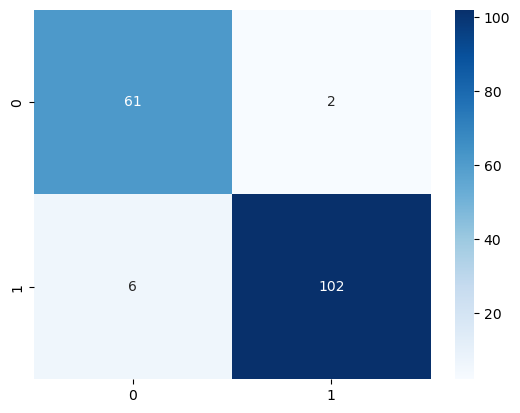

In [145]:
from sklearn.metrics import confusion_matrix

# SVM
svm_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(svm_matrix, annot=True, cmap='Blues', fmt='g')

We see that of the $61 + 6 = 67$ people that did not have a heart disease, 61 were correctly classified. Of the $2 + 102 = 104$ -> 102 were correctly classified for the *linear kernel*

<Axes: >

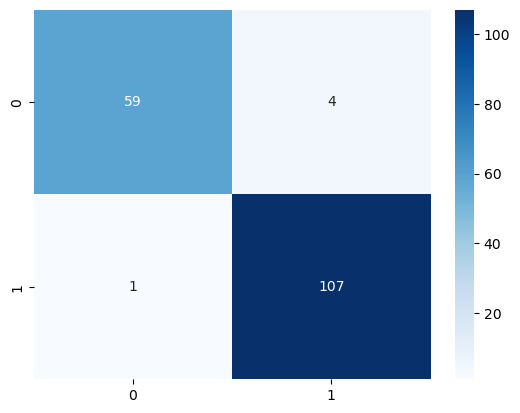

In [144]:
# Random Forest
rf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(rf_matrix, annot=True, cmap='Blues', fmt='g')

We see that of the $59 + 1 = 60$ people that did not have a heart disease, 59 were correctly classified. Of the $4 + 107 = 111$ -> 107 were correctly classified for the *Random Forest*

<Axes: >

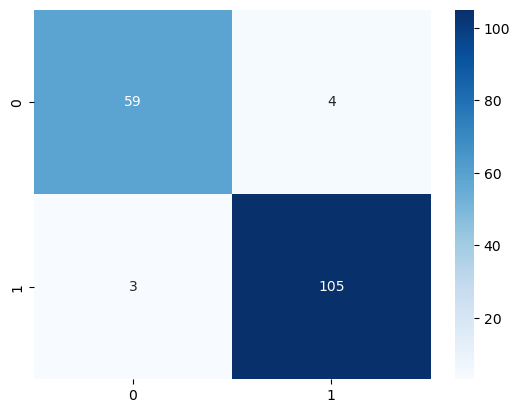

In [143]:
# Gradient Boosting
gb_matrix = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(gb_matrix, annot=True, cmap='Blues', fmt='g')

We see that of the $59 + 3 = 62$ people that did not have a heart disease, 59 were correctly classified. Of the $4 + 105 = 109$ -> 105 were correctly classified for the *Gradient Boosting*.

<Axes: >

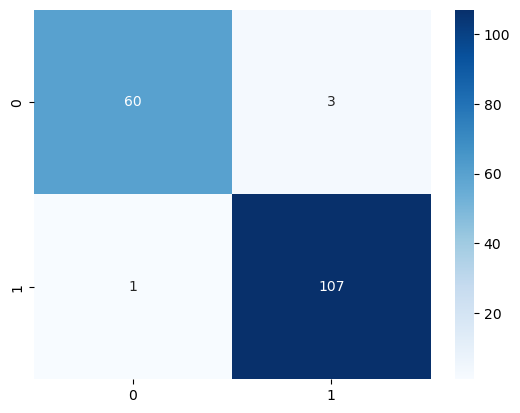

In [142]:
# GAM Full
gam_matrix_full = confusion_matrix(y_test, y_pred_gam_full)
sns.heatmap(gam_matrix_full, annot=True, cmap='Blues', fmt='g')

We see that of the $60 + 1 = 61$ people that did not have a heart disease, 59 were correctly classified. Of the $3 + 107 = 110$ -> 107 were correctly classified for the *GAM Full*.

<Axes: >

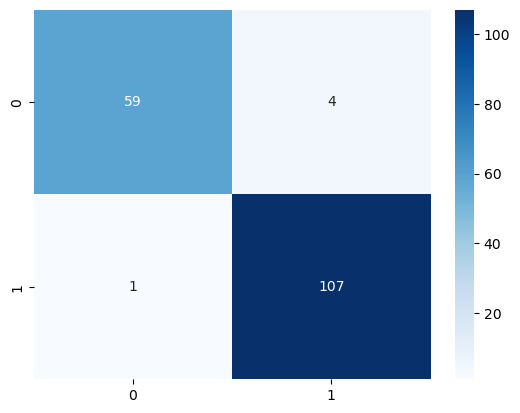

In [140]:
# GAM
gam_matrix = confusion_matrix(y_test, y_pred_gam)
sns.heatmap(gam_matrix, annot=True, cmap='Blues', fmt='g')

We see that of the $59 + 1 = 60$ people that did not have a heart disease, 59 were correctly classified. Of the $4 + 107 = 111$ -> 107 were correctly classified for the *GAM New*.

### Pros and cons for the different models

#### SVM Kernels

The *linear kernel* performs very well the the data is linearly separable, which seems to be the case for this dataset and scales well to higher dimensions of data. It has an easy interpretation as well. When the data has complex, non-linear boundaries, this model tends to perform worse and can perform worse when working with larger datasets due to the increased computational costs. 

The *polynomial kernel* can model these non-linear and complex boundaries if they exist and is very flexible when it comes to the degrees of the polynomial. With higher degrees of the polynomial it can be computationally intensive and has a higher risk of overfitting the data, this is especially the case with higher degree polynomials. 

The *RBF* can handle the non-linearities by mapping the inputs into a higher dimensional space and can even be accurate when the data is not lineary separable. With these advantages there comes the cons of computation when mapping the inputs to higher dimensional space and requires careful selection of hyperparameters in order to achieve a well functioning model. 

#### Random Forest

*Random forest* are generally a good approach for both classification and regression and can handle both categorical and numerical inputs, thereby no encoding of the variables will be necessary. Implicitly, they perform feature selection and generate uncorrelated decision trees and works well with higher dimensional datasets. One of the most important features of random forest comes from the fact they can handle both linear and non-linear patterns in the data. For this specific case, we did not know in advance wheter a complex non-linear pattern was within the data -> this case might indicate that the data is linearly separable, but random forest might've performed well either way. There is a high degree of balancing between the bias-variance trade off for this model as well, which makes it's purpose very general.  

On the other hand they are not always easy to interpret, even though they inherently provide us with feature importance, they do not provide with clear transparency as to how these results came to be, which is also why they are referred to as a black box algorithm. 


#### Gradient boosting

The *Gradient boosting* ensemble method can handle various types of predictors and relationships. This technique improves upon the weaknesses of Adaboost, which performs well when there is little noise in the data. However if the data becomes more noisy, for example due to outliers, or uncertainty in the true input-output relationship, the performance can perform worse. Gradient boosting is a more robust alternative, at the expense of a more computationally intensive methode. 

#### GAM's

*Generalized Additive Models* provide a flexible approch to modelling by allowing for non-linear relationships between each feature and the target variable. We can model the partial dependency of each of these features on the target as well to gain even more interpretability. Because of this it can be very robust to correlation between predictors. As always flexibility comes at the cost of computation, and GAM's are intensive. They require a careful selection of the features and the number of splines. If the correct preprocessing and exploratory analysis is not done correctly the model may well be misspecified resulting in poorer performance. 

### 6. Conclusion
* Summarize the findings from the model comparisons.
* Provide insights into which model performed best and hypothesize why.
* Discuss any potential improvements or alternative approaches that could be explored.

The models have very similar performance, but the results, in my view, give a clear indication as to which performed well. The Linear SVM kernel, performed among the highest of all the models, even though being one of the simplest methods. This could be an indiciation that the data does not have as excessive intricate non-linear patterns in the data that need to be explain by Radial Basis function or high degree polynomial SMV kernels. The GAM model also performed very well, and could potentially even have significantly increased performance, if coupled, with feature engineering and further investigations into the amount of splines to use.  

A potential improvement to the models could be to introduce regularization in order to penalize for the dimensions of the dataset. 

## How to Submit
- First, a Jupyter Notebook containing all the code, comments, and analysis.
- Second report cells in the same Jupyter Notebook, summarizing your findings, including results and a discussion of the results.
- Finally convert the Jupyter Notebook to PDF.
- **Don't write your name**.
- Upload the PDF into convas.

## Evaluation Criteria (peer grading)
- Correctness of the implementation of all regression and classification models. (2 points)
- Quality of the EDA and preprocessing steps. (1 point)
- Depth of the analysis in comparing the models.(1 point)
- Clarity and organization of the submitted report and Jupyter Notebook. (1 point)

